In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "flower-fgvc"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/flower-fgvc
common	     data		datautils    Index.ipynb  models  README.md
config.yaml  data_processor.py	experiments  index.py	  output  run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

!pip install transformers


In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder

#!tar xf data/102flowers.tgz -C data/

In [4]:
#set up some imports

import numpy as np
import torch
import random
from torchvision import transforms

# custom imports

from common.utils import init_config, get_exp_params, get_modelinfo
from datautils.dataset import FlowerDataset
from datautils.datareader import get_file_paths
from experiments.classification import Classification
from common.visualization import Visualization
from experiments.classifier_tester import ModelTester
from models.custom_models import get_model

In [5]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
config_params = init_config()
print('nb', config_params)

nb {'data_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc', 'use_gpu': True}


In [7]:
# read experiment params

exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 399, 'crop_dim': 300}, 'train': {'batch_size': 64, 'loss': 'ecc', 'epoch_interval': 10, 'num_epochs': 30, 'lamda1': 0.01, 'lamda2': 1.2, 'enable_lr_decay': False, 'lr_step': 10, 'lr_decay': 0.1, 'ecc_alpha': 0.5, 'shared_space_numfeats': 4096}, 'model': {'name': 'resnet18', 'optimizer': 'sgd', 'lr': 1e-05, 'weight_decay': 1e-05, 'amsgrad': True, 'momentum': 0.8, 'build_on_pretrained': False, 'pretrained_filename': '/models/checkpoints/last_model.pt'}, 'dataset': {'size': 'full'}}


In [8]:
composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])

train_fns, val_fns, test_fns, _ = get_file_paths(config_params['data_dir'])
ftr_dataset = FlowerDataset(config_params['data_dir'], train_fns, composed_transforms)
val_dataset = FlowerDataset(config_params['data_dir'], val_fns, composed_transforms)
test_dataset = FlowerDataset(config_params['data_dir'], test_fns, composed_transforms)
sm_trlen = int(0.3 * len(ftr_dataset))
sm_telen = int(0.03 * len(test_dataset))
sm_vlen = int(0.3 * len(val_dataset))

sm_ftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(sm_trlen)))
sm_val_dataset = torch.utils.data.Subset(val_dataset, list(range(sm_vlen)))
sm_test_dataset = torch.utils.data.Subset(test_dataset, list(range(sm_telen)))

print('Full train dataset length', len(ftr_dataset))
print('Subset train dataset length', sm_trlen)
print('\nFull validation dataset length', len(val_dataset))
print('Subset validation dataset length', sm_vlen)
print('\nFull test dataset length', len(test_dataset))
print('Subset test dataset length', sm_telen)

Full train dataset length 1020
Subset train dataset length 306

Full validation dataset length 1020
Subset validation dataset length 306

Full test dataset length 6149
Subset test dataset length 184


In [9]:
# cell that trains the model
if exp_params['dataset']['size'] == 'subset':
    classification = Classification(sm_ftr_dataset, sm_val_dataset)
    classification.run_fgvc_pipeline()
else:
    classification = Classification(ftr_dataset, val_dataset)
    classification.run_fgvc_pipeline()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Training of classifier...



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-cae16f8555d7>", line 7, in <cell line: 2>
    classification.run_fgvc_pipeline()
  File "/content/drive/MyDrive/Personal-Projects/flower-fgvc/experiments/classification.py", line 224, in run_fgvc_pipeline
    self.__conduct_training(model, optimizer, train_loader, val_loader, tr_len, val_len, model_info)
  File "/content/drive/MyDrive/Personal-Projects/flower-fgvc/experiments/classification.py", line 85, in __conduct_training
    self.text_features = self.__get_clip_features4classes().to(self.device)
  File "/content/drive/MyDrive/Personal-Projects/flower-fgvc/experiments/classification.py", line 50, in __get_clip_features4classes
    model = CLIPModel.from_pretrained(model_name)
  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 3579,

TypeError: object of type 'NoneType' has no len()


Model results




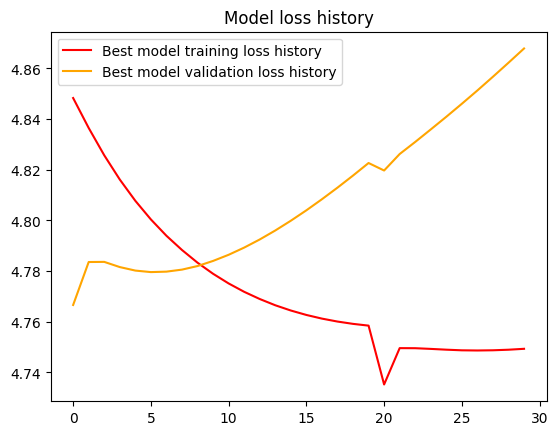

In [11]:
model_info = get_modelinfo('')
vis = Visualization(model_info)
vis.get_results()

In [12]:
# cell that tests the model
model = get_model(102, exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config_params["device"])))

if exp_params['dataset']['size'] == 'subset':
    mt = ModelTester(model, sm_test_dataset, composed_transforms)
    mt.test_and_plot()
else:
    mt = ModelTester(model, sm_test_dataset, composed_transforms)
    mt.test_and_plot()

<ipython-input-12-d1cd05556ef8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.de


Test Loss: 1.5548673989116282
Test Accuracy: tensor(0.1250, device='cuda:0') 

